# Initial QC on the unfiltered matrices
This notebook generates some basic QC stats and plots for unfiltered matrices provided (both gene UMI counts and guide assignment)

# Set-up

In [1]:
# imports
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
from mudata import MuData
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn3

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Paths
path_gene_h5ad = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_HUES8-definitive-endoderm-differentiation_TF-Perturb-seq/Transcriptome_Analysis/anndata.h5ad"
path_guide_h5ad = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_HUES8-definitive-endoderm-differentiation_TF-Perturb-seq/Perturbation_information/guide_assignment_matrix.h5ad"

path_out = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_HUES8-definitive-endoderm-differentiation_TF-Perturb-seq"
os.makedirs(path_out, exist_ok=True)

# Load data

In [3]:
# Read in gene UMI counts
gene = sc.read_h5ad(path_gene_h5ad)
gene

AnnData object with n_obs × n_vars = 191096 × 38606
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [4]:
# Read in guide assignment matrix
guide = sc.read_h5ad(path_guide_h5ad)
guide

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 157190 × 13166
    var: 'protospacer_ID', 'protospacer', 'intended_target_name', 'genomic_element', 'reverse_compliment', 'Huangfu_id', 'Huangfu_name', 'type'

# Number of sequencing lanes

In [5]:
# Split barcode and lane from index
gene.obs["barcode"] = gene.obs.index.str.split("-").str[0]
gene.obs["lane"] = gene.obs.index.str.split("-").str[1]
gene.obs["lane"].value_counts()

lane
8    25901
4    24879
5    24709
6    24621
2    23398
7    22999
1    22664
3    21925
Name: count, dtype: int64

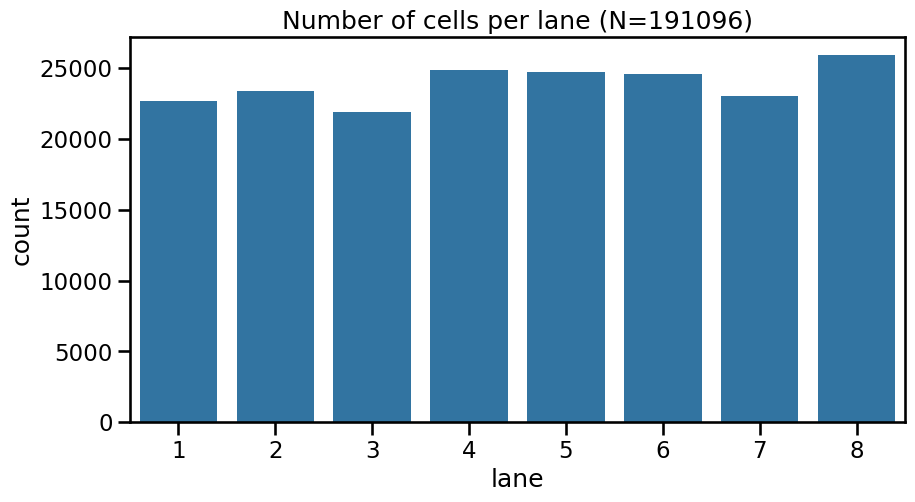

In [6]:
# Plot the number of cells per lane
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x="lane", data=gene.obs, ax=ax)
    ax.set_title(f"Number of cells per lane (N={gene.n_obs})")
    plt.show()

In [7]:
# Split barcode and lane from index
guide.obs["barcode"] = guide.obs.index.str.split("-").str[0]
guide.obs["lane"] = guide.obs.index.str.split("-").str[1]
guide.obs["lane"].value_counts()

lane
8    21605
4    20635
6    20335
5    19791
2    19210
7    19131
1    18473
3    18010
Name: count, dtype: int64

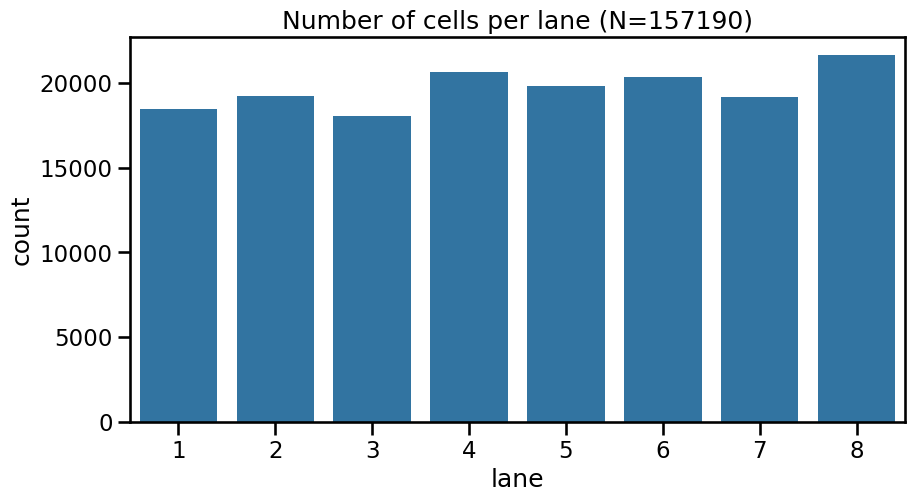

In [8]:
# Plot the number of cells per lane
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x="lane", data=guide.obs, ax=ax)
    ax.set_title(f"Number of cells per lane (N={guide.n_obs})")
    plt.show()

# Transcriptome

Min. count: 500.0
Max count: 44441.0


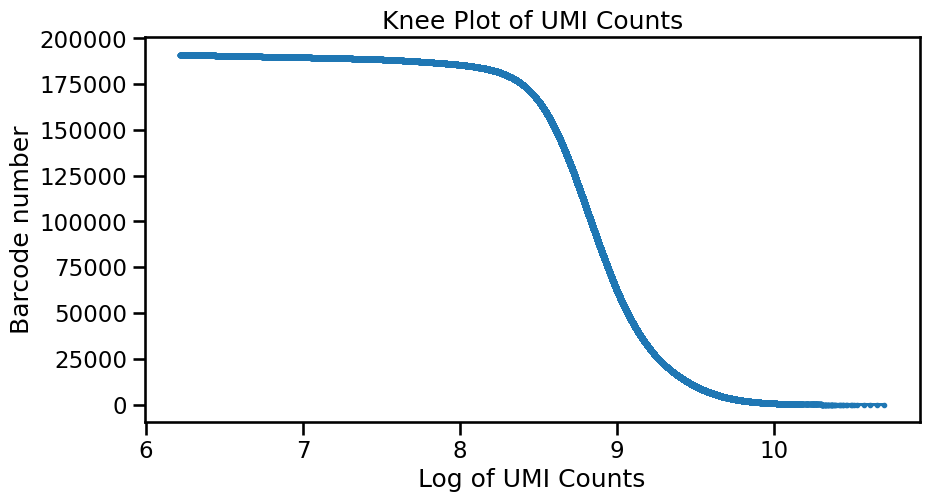

In [9]:
# # Knee plot of UMI count (x-axis) vs. barcode rank
knee_df = pd.DataFrame({
    'sum': np.array(gene.X.sum(1)).flatten(),
    'barcodes': gene.obs_names.values
})
knee_df = knee_df.sort_values('sum', ascending=False).reset_index(drop=True)
knee_df['sum_log'] = np.log1p(knee_df['sum'])
with sns.plotting_context("talk"):
    plt.figure(figsize=(10, 5))
    plt.plot(knee_df['sum_log'], knee_df.index, marker='o', linestyle='-', markersize=3)
    plt.ylabel('Barcode number')
    plt.xlabel('Log of UMI Counts')
    plt.title('Knee Plot of UMI Counts')
print(f"Min. count: {knee_df['sum'].min()}\nMax count: {knee_df['sum'].max()}")

In [10]:
# Calculate QC metrics including percentage of mitochondrial and ribosomal genes
gene.var["MT"] = gene.var_names.str.startswith("MT-")
gene.var["RIBO"] = gene.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(gene, qc_vars=["MT", "RIBO"], inplace=True, log1p=True)

/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this 

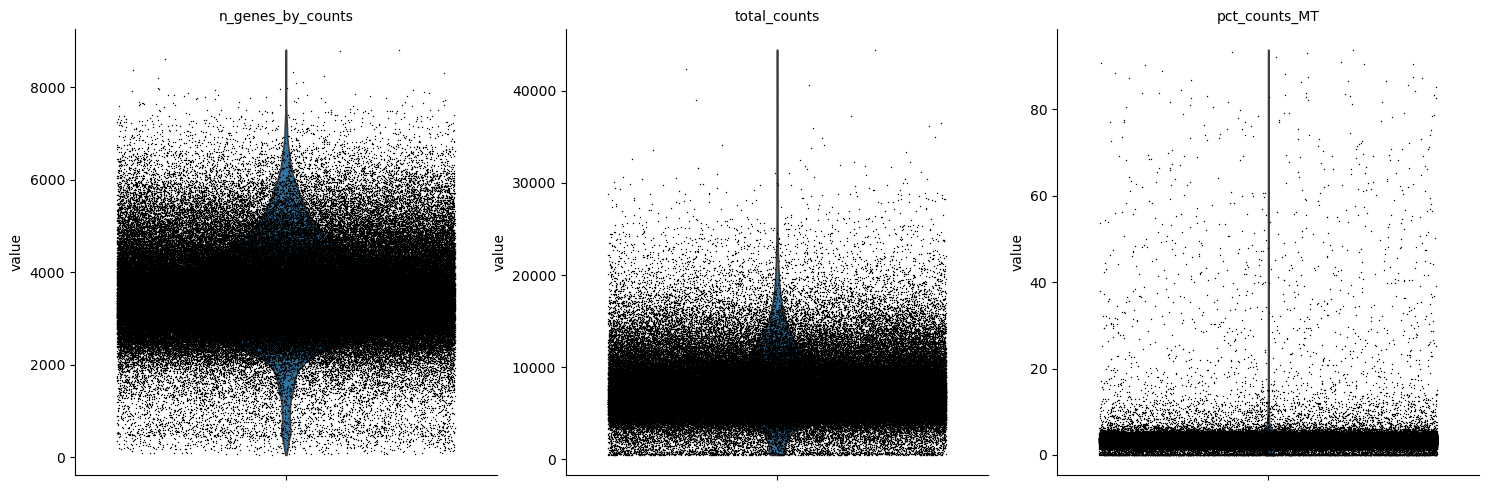

In [11]:
# Plot QC metrics as scanpy violins
sc.pl.violin(
    gene,
    ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
    jitter=0.4,
    multi_panel=True,
)

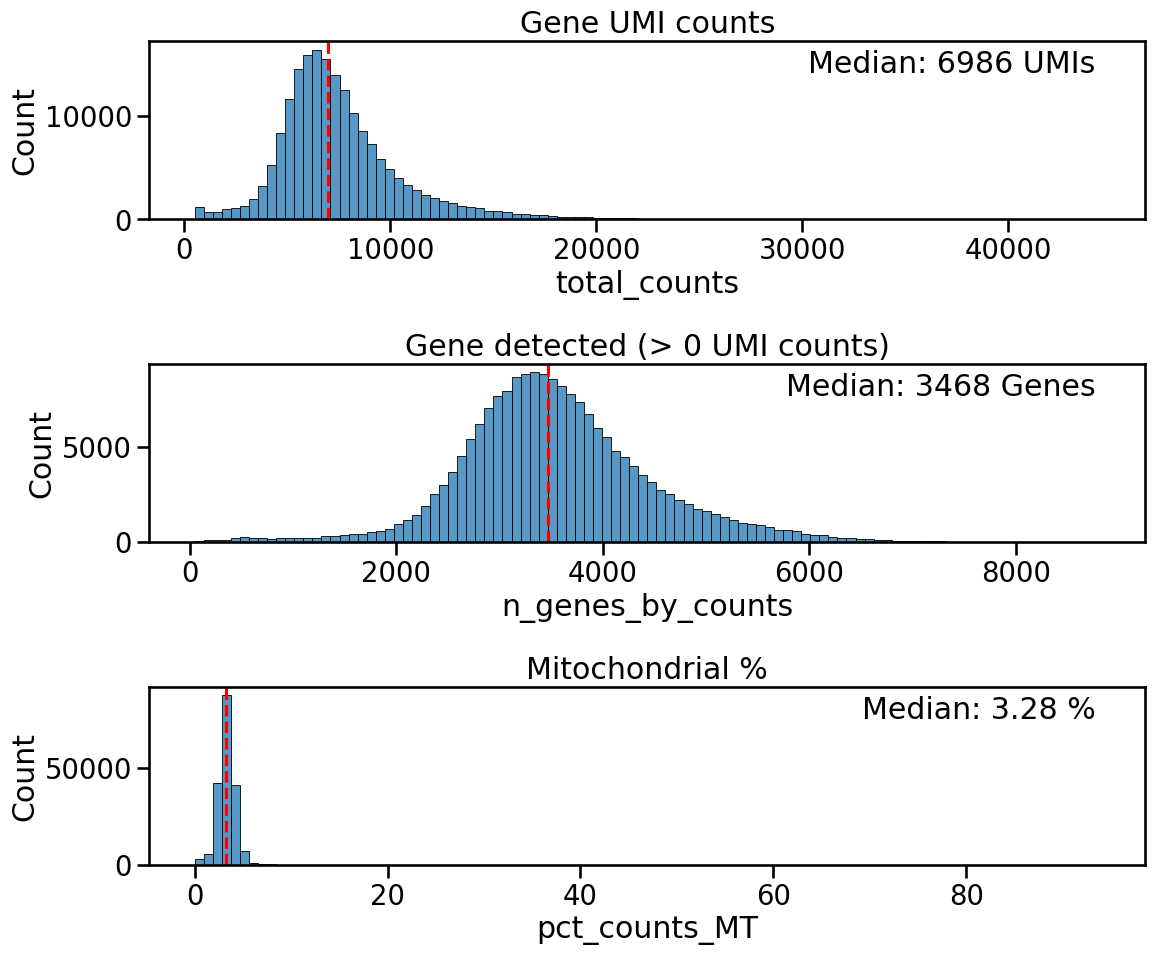

In [12]:
# Like these better: plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(3, 1, figsize=(12, 10))

    # Plotting total counts
    sns.histplot(gene.obs["total_counts"], bins=100, ax=ax[0])
    ax[0].axvline(gene.obs["total_counts"].median(), color="red", linestyle="--")
    ax[0].text(0.95, 0.95, f"Median: {gene.obs['total_counts'].median():.0f} UMIs", ha="right", va="top", transform=ax[0].transAxes)
    ax[0].set_title("Gene UMI counts")

    # Plotting percentage of mitochondrial genes
    sns.histplot(gene.obs["n_genes_by_counts"], bins=100, ax=ax[1])
    ax[1].axvline(gene.obs["n_genes_by_counts"].median(), color="red", linestyle="--")
    ax[1].text(0.95, 0.95, f"Median: {gene.obs['n_genes_by_counts'].median():.0f} Genes", ha="right", va="top", transform=ax[1].transAxes)
    ax[1].set_title("Gene detected (> 0 UMI counts)")

    # Plotting percentage of mitochondrial genes
    sns.histplot(gene.obs["pct_counts_MT"], bins=100, ax=ax[2])
    ax[2].axvline(gene.obs["pct_counts_MT"].median(), color="red", linestyle="--")
    ax[2].text(0.95, 0.95, f"Median: {gene.obs['pct_counts_MT'].median():.2f} %", ha="right", va="top", transform=ax[2].transAxes)
    ax[2].set_title("Mitochondrial %")

    plt.tight_layout()
    plt.show()

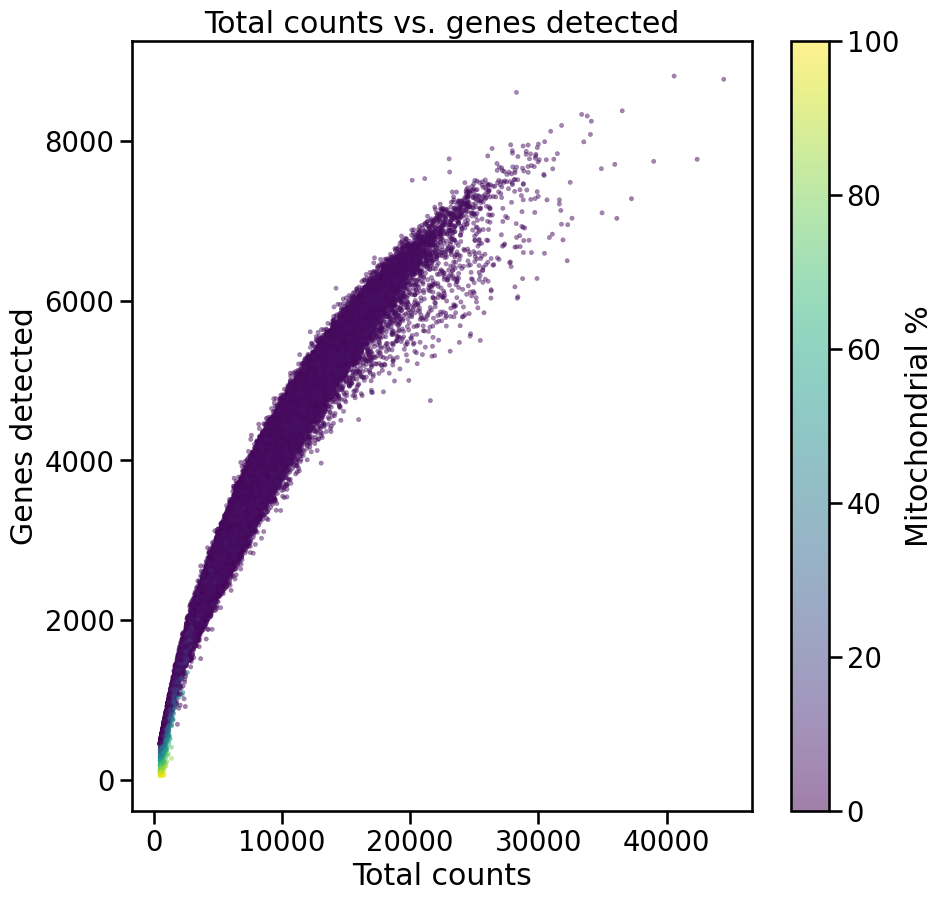

In [13]:
# Scatterplot of total counts vs. genes detected, colored by mitochondrial content (viridis continuous color map)
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x="total_counts", y="n_genes_by_counts", hue="pct_counts_MT", data=gene.obs, ax=ax, alpha=0.5, s=10, palette="viridis", edgecolor=None)
    ax.get_legend().remove()
    plt.colorbar(ax.collections[0], ax=ax, label="Mitochondrial %")
    ax.collections[0].set_clim(0, 100)
    ax.set_xlabel("Total counts")
    ax.set_ylabel("Genes detected")
    ax.set_title("Total counts vs. genes detected")
    plt.show()

# Guide 

In [14]:
# Calculate QC metrics for guide assignments
sc.pp.calculate_qc_metrics(guide, inplace=True, log1p=True, var_type="guides")

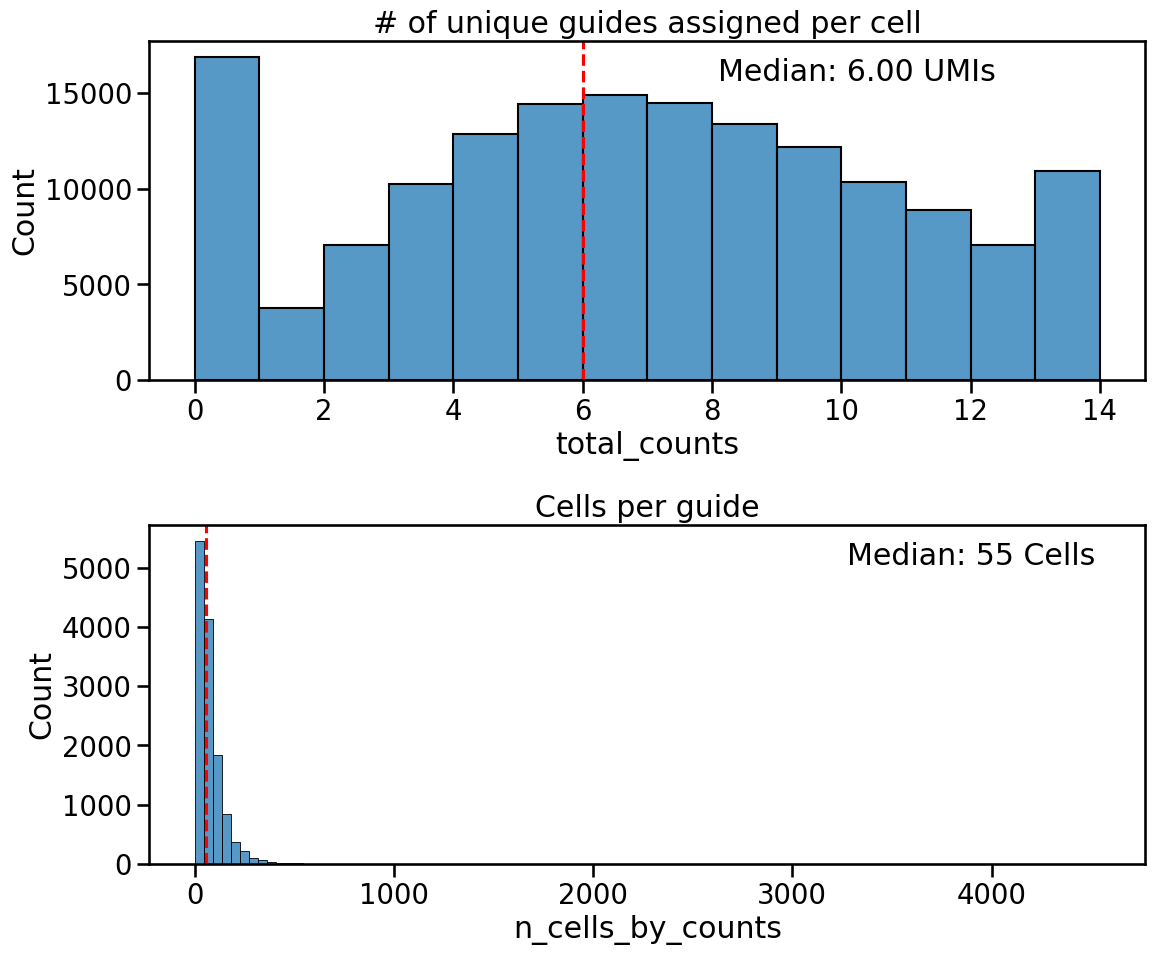

In [15]:
# Plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Guide assignment distribution per cell
    sns.histplot(guide.obs["total_counts"],bins=14, ax=ax[0])
    ax[0].axvline(guide.obs["total_counts"].median(), color="red", linestyle="--")
    ax[0].text(0.85, 0.95, f"Median: {guide.obs['total_counts'].median():.2f} UMIs", ha="right", va="top", transform=ax[0].transAxes)
    ax[0].set_title("# of unique guides assigned per cell")

    # 
    sns.histplot(guide.var["n_cells_by_counts"], bins=100, ax=ax[1])
    ax[1].axvline(guide.var["n_cells_by_counts"].median(), color="red", linestyle="--")
    ax[1].text(0.95, 0.95, f"Median: {guide.var['n_cells_by_counts'].median():.0f} Cells", ha="right", va="top", transform=ax[1].transAxes)
    ax[1].set_title("Cells per guide")

    plt.tight_layout()
    plt.show()

In [16]:
# how many cells have no guides
print(f"Cells with no guides: {np.sum(guide.obs['n_guides_by_counts'] == 0)}")

Cells with no guides: 16842


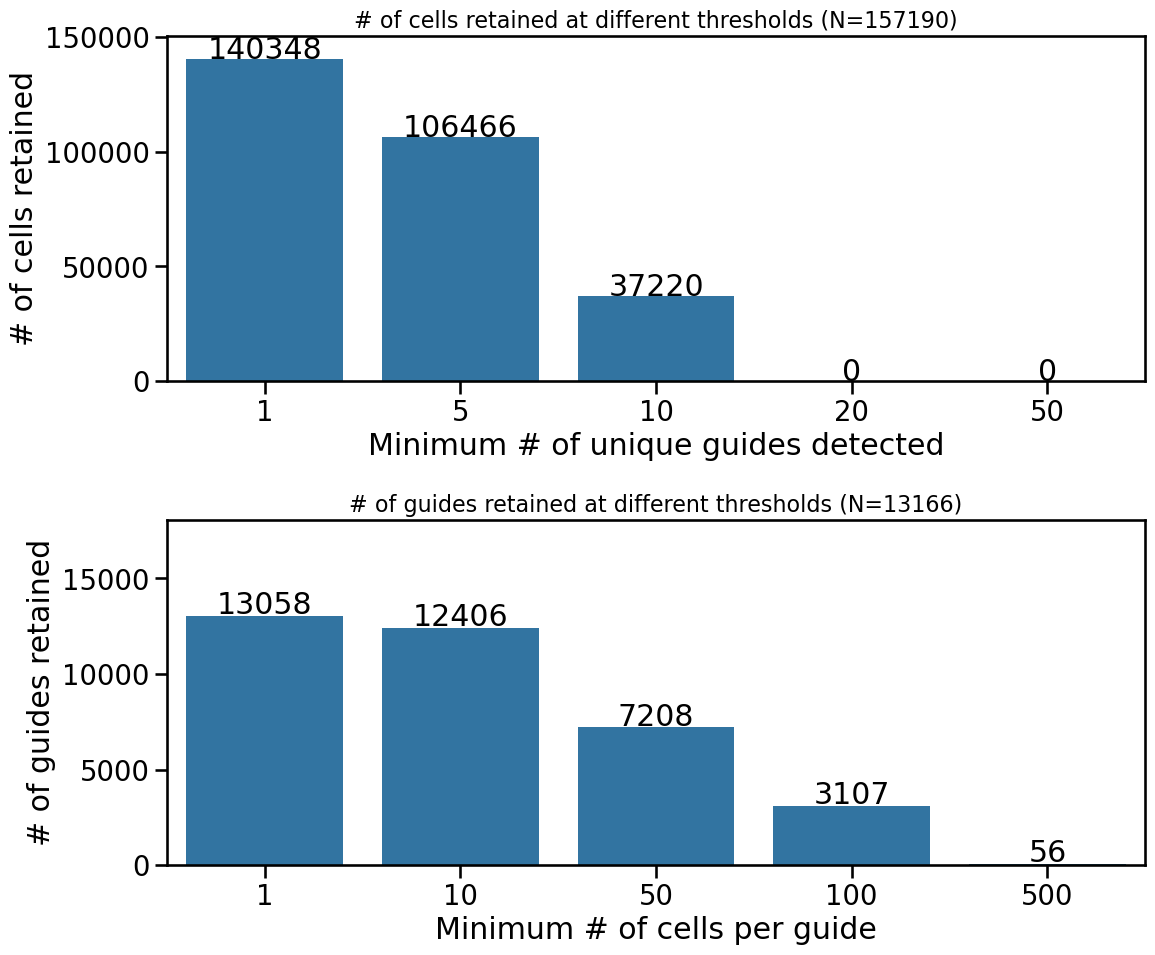

In [17]:
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # How many cells would be retained if we filter for min_guides?
    min_guides_thresholds = [1, 5, 10, 20, 50]
    num_cells_at_thresholds = {threshold: np.sum(guide.obs['n_guides_by_counts'] >= threshold) for threshold in min_guides_thresholds}
    sns.barplot(x=list(num_cells_at_thresholds.keys()), y=list(num_cells_at_thresholds.values()), ax=ax[0])
    for i, v in enumerate(num_cells_at_thresholds.values()):
        ax[0].text(i, v + 100, str(v), color='black', ha="center")
    ax[0].set_ylim(0, max(num_cells_at_thresholds.values()) + 10000)
    ax[0].set_xlabel("Minimum # of unique guides detected")
    ax[0].set_ylabel("# of cells retained")
    ax[0].set_title("# of cells retained at different thresholds (N={})".format(guide.n_obs), fontsize=16)

    # How many guides would be retained if we filter for min_cells?
    min_cells_thresholds = [1, 10, 50, 100, 500]
    num_guides_at_thresholds = {threshold: np.sum(guide.var['n_cells_by_counts'] >= threshold) for threshold in min_cells_thresholds}
    sns.barplot(x=list(num_guides_at_thresholds.keys()), y=list(num_guides_at_thresholds.values()), ax=ax[1])
    for i, v in enumerate(num_guides_at_thresholds.values()):
        ax[1].text(i, v + 100, str(v), color='black', ha="center")
    ax[1].set_ylim(0, max(num_guides_at_thresholds.values()) + 5000)
    ax[1].set_xlabel("Minimum # of cells per guide")
    ax[1].set_ylabel("# of guides retained")
    ax[1].set_title("# of guides retained at different thresholds (N={})".format(guide.n_vars), fontsize=16)

    plt.tight_layout()
    plt.show()
    

# Number of cells per target

In [18]:
var_df = guide.var
var_df["type"].value_counts()

type
targeting           13141
positive_control       19
Name: count, dtype: int64

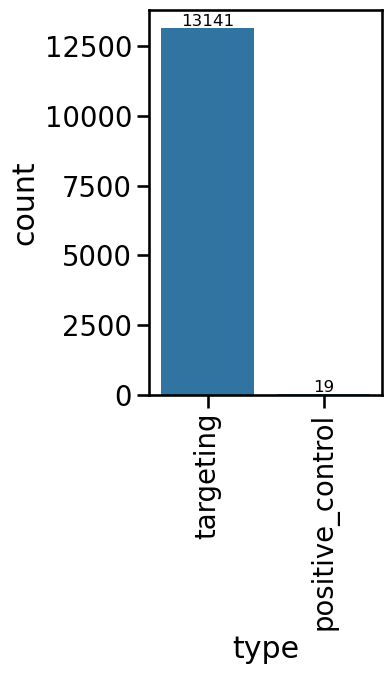

In [19]:
# Plot the distribution of guide types as countplot
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(3, 5))
    sns.countplot(x=var_df["type"], order=var_df["type"].value_counts().index, ax=ax)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
    plt.xticks(rotation=90)
    plt.show()

In [20]:
# Aggregate the guide information to the gene level (intended_target_name)
target_df = var_df.groupby("intended_target_name").agg(
    n_cells_per_guide=("n_cells_by_counts", "sum"),
    type=("type", "first"),
    guides=("protospacer_ID", lambda x: x.unique().tolist()),
)

/tmp/ipykernel_827437/3652798259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_df = var_df.groupby("intended_target_name").agg(


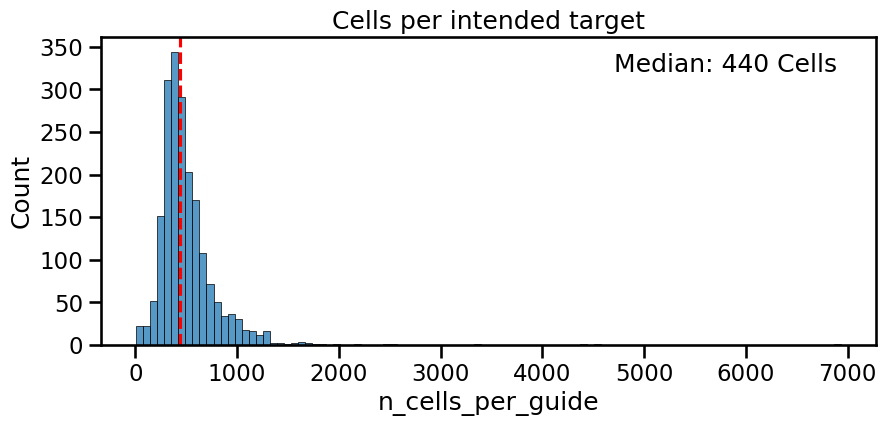

In [21]:
# Plot the distribution of cells per guide and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.histplot(target_df["n_cells_per_guide"], bins=100, ax=ax)
    ax.axvline(target_df["n_cells_per_guide"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {target_df['n_cells_per_guide'].median():.0f} Cells", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Cells per intended target")

/tmp/ipykernel_827437/4170444161.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for type, group in target_df.groupby("type"):


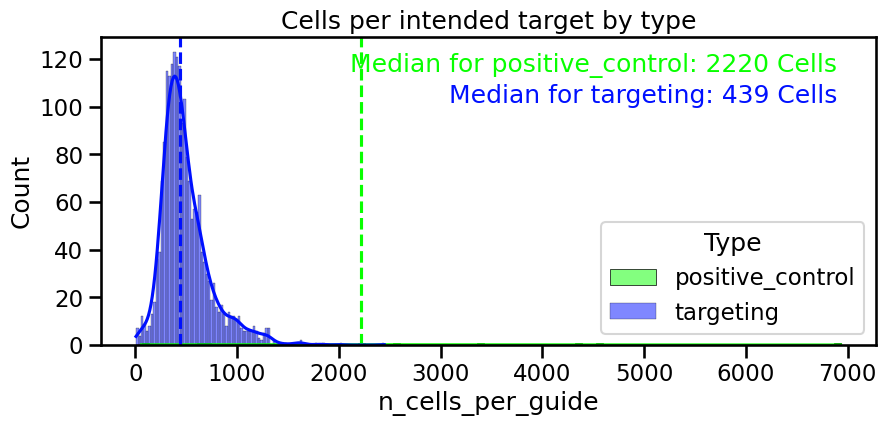

In [22]:
# Plot the distribution of cells per guide and annotate with median (red dashed line and text in upper right corner)
# Split by type
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 4))
    i = 0
    for type, group in target_df.groupby("type"):
        palette = sns.color_palette("hsv", len(target_df["type"].unique()))
        color = palette[list(target_df["type"].unique()).index(type)]
        sns.histplot(group["n_cells_per_guide"], bins=100, label=type, kde=True, ax=ax, color=color)
        ax.axvline(group["n_cells_per_guide"].median(), color=color, linestyle="--")
        ax.text(0.95, 0.95 - (i * 0.1), f"Median for {type}: {group['n_cells_per_guide'].median():.0f} Cells", ha="right", va="top", transform=ax.transAxes, color=color)
        i+=1
    ax.set_title("Cells per intended target by type")
    ax.legend(title='Type', loc='lower right')

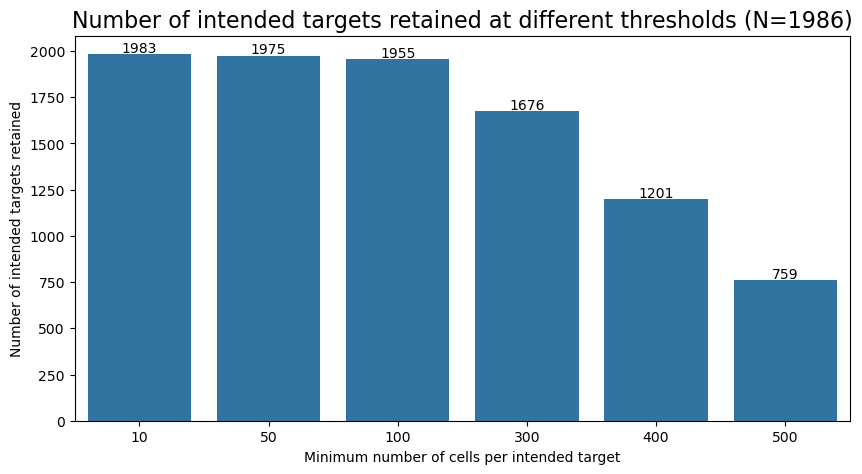

In [23]:
# How many targets would be retained if we filter for min_cells?
fig, ax = plt.subplots(figsize=(10, 5))
min_cells_thresholds = [10, 50, 100, 300, 400, 500]
num_targets_at_thresholds = {threshold: np.sum(target_df['n_cells_per_guide'] >= threshold) for threshold in min_cells_thresholds}
sns.barplot(x=list(num_targets_at_thresholds.keys()), y=list(num_targets_at_thresholds.values()))
for i, v in enumerate(num_targets_at_thresholds.values()):
    ax.text(i, v + 10, str(v), color='black', ha="center")
ax.set_ylim(0, max(num_targets_at_thresholds.values()) + 100)
ax.set_xlabel("Minimum number of cells per intended target")
ax.set_ylabel("Number of intended targets retained")
ax.set_title("Number of intended targets retained at different thresholds (N={})".format(len(target_df)), fontsize=16)
plt.show()


/tmp/ipykernel_827437/3108686892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_targets["n_cells_per_guide"].values, y=list(top_20_targets.index.values), ax=ax, palette="Set2")
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
 

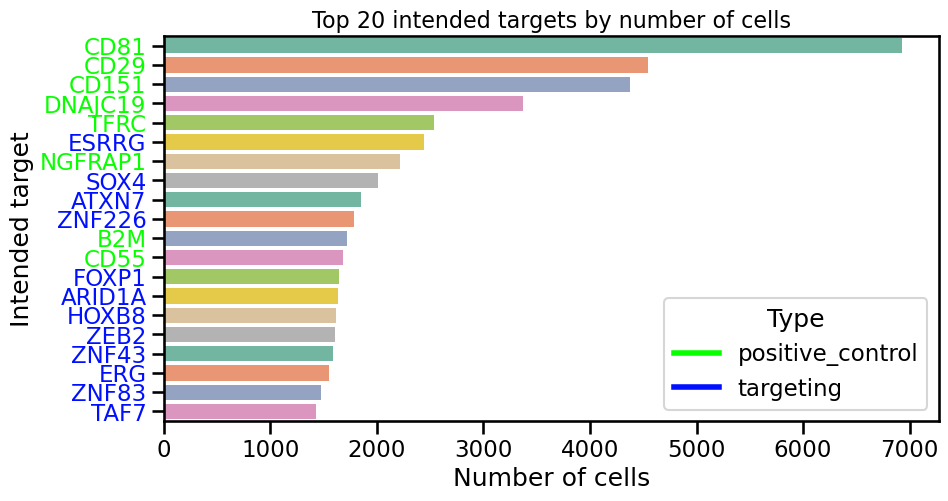

In [24]:
# Plot the top 20 intended targets by number of cells, color index by type
with sns.plotting_context("talk"):
    sorted_target_df = target_df.sort_values("n_cells_per_guide", ascending=False)
    top_20_targets = sorted_target_df.head(20)
    palette = sns.color_palette("hsv", len(top_20_targets["type"].unique()))
    color_dict = {type: palette[list(top_20_targets["type"].unique()).index(type)] for type in top_20_targets["type"].unique()}
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=top_20_targets["n_cells_per_guide"].values, y=list(top_20_targets.index.values), ax=ax, palette="Set2")
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("Intended target")
    ax.set_title("Top 20 intended targets by number of cells", fontsize=16)
    # Color y-axis labels by type
    y_labels = ax.get_yticklabels()
    for i, target in enumerate(top_20_targets.index):
        y_labels[i].set_color(color_dict[top_20_targets.loc[target, "type"]])
    # Add legend for type
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in palette]
    labels = list(top_20_targets["type"].unique())
    ax.legend(handles, labels, title='Type', loc='lower right')
    plt.show()

# Singlet detection (if performed)

In [25]:
# Run scrublet to identify doublets on gene UMI count matrix
#sc.pp.scrublet(
#    gene,
#    random_state=1234,
#    #batch_key="lane",
#)
gene.obs["predicted_doublet"] = False

In [26]:
# How many are predicted doublets
gene.obs["predicted_doublet"].value_counts()

predicted_doublet
False    191096
Name: count, dtype: int64

# How many cells pass each step of filtering?

In [27]:
# Gene UMI counts filtering parameters
min_genes = 500
pct_mito = 20

# Guide assignment filtering parameters
min_guides_per_cell = 1

In [28]:
# Barcode mask
gene_umi_barcodes = gene.obs.index[(gene.obs['n_genes_by_counts'] >= min_genes) & (gene.obs['pct_counts_MT'] <= pct_mito)]
guide_assignment_barcodes = guide.obs.index[guide.obs['n_guides_by_counts'] >= min_guides_per_cell]
singlet_barcodes = gene.obs.index[~gene.obs["predicted_doublet"]]
combined_cell_barcodes = list(set(gene_umi_barcodes).intersection(set(guide_assignment_barcodes)).intersection(set(singlet_barcodes)))
print(f"Gene UMI counts: {len(gene_umi_barcodes)} barcodes")
print(f"Guide assignments: {len(guide_assignment_barcodes)} barcodes")
print(f"Singlets: {len(singlet_barcodes)} barcodes")
print(f"Combined cell barcodes: {len(combined_cell_barcodes)} barcodes")

Gene UMI counts: 190118 barcodes
Guide assignments: 140348 barcodes
Singlets: 191096 barcodes
Combined cell barcodes: 140348 barcodes


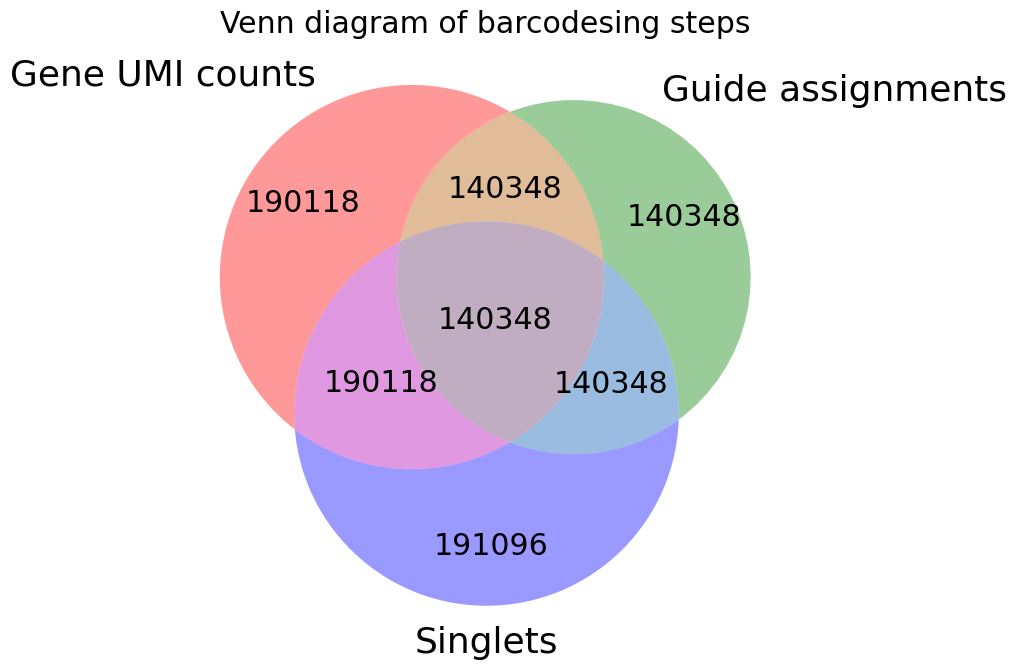

In [29]:
# Venn diagram of the barcodesing steps
with sns.plotting_context("talk", font_scale=1.2):
    plt.figure(figsize=(8, 8))
    subsets = {
        '100': len(gene_umi_barcodes),
        '010': len(guide_assignment_barcodes),
        '001': len(singlet_barcodes),
        '110': len(np.intersect1d(gene_umi_barcodes, guide_assignment_barcodes)),
        '101': len(np.intersect1d(gene_umi_barcodes, singlet_barcodes)),
        '011': len(np.intersect1d(guide_assignment_barcodes, singlet_barcodes)),
        '111': len(np.intersect1d(np.intersect1d(gene_umi_barcodes, guide_assignment_barcodes), singlet_barcodes))
    }
    venn3(subsets=subsets,
          set_labels=('Gene UMI counts', 'Guide assignments', 'Singlets'))
    plt.title("Venn diagram of barcodesing steps")
    plt.show()

# How many features pass each step of filtering?

In [30]:
# Gene UMI counts filtering
min_cells = 3

# Guide assignment filtering
min_cells_per_guide = 5

In [31]:
# gene mask
gene_umi_filter = (gene.var['n_cells_by_counts'] >= min_cells)
guide_assignment_filter = (guide.var['n_cells_by_counts'] >= min_cells_per_guide)
print(f"Gene UMI counts: {np.sum(gene_umi_filter)} genes pass the filter")
print(f"Guide assignments: {np.sum(guide_assignment_filter)} guides pass the filter")

Gene UMI counts: 34617 genes pass the filter
Guide assignments: 12784 guides pass the filter


# Make a MuData object

In [32]:
mdata = MuData({
    "gene": gene[combined_cell_barcodes, :].copy(),
    "guide": guide[combined_cell_barcodes, :].copy(),
})
mdata

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 140348 × 51772
  var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  2 modalities
    gene:	140348 x 38606
      obs:	'barcode', 'lane', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'predicted_doublet'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'MT', 'RIBO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    guide:	140348 x 13166
      obs:	'barcode', 'lane', 'n_guides_by_counts', 'log1p_n_guides_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_guides', 'pct_counts_in_top_100_guides', 'pct_counts_in_top_200_guides', 'pct_counts_in_top_500_guides'
      var:	'protospacer_ID', 'protospacer', 'intended_target_name', 'genomic_element', 'reverse_compliment', 'Huangfu_id', 'Huangfu_name', 'type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [33]:
mdata.obs["lane"] = mdata.mod["gene"].obs["lane"]
mdata.obs["barcode"] = mdata.mod["gene"].obs["barcode"]

In [34]:
mdata.write(f"{path_out}/mdata_filtered.h5mu")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 844, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 827, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


# DONE!

---